In [1]:
%matplotlib inline
from qutip import*
from pylab import*
from numpy import*
import scipy.constants as sc
import scipy.fftpack
from scipy.fftpack import fft, ifft
from scipy import signal

# Understand FFT scipy

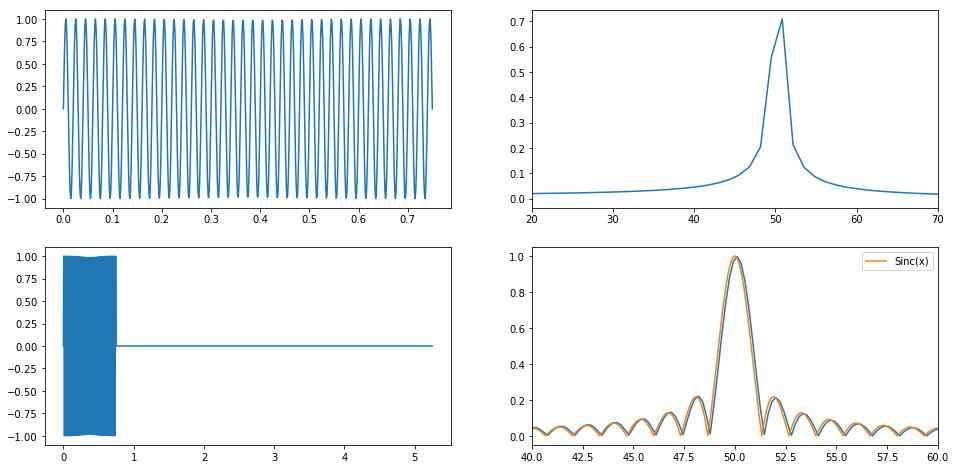

In [10]:
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0

#### Define normal fft of sin function

x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) #sin with freq 50

yf = scipy.fftpack.fft(y) #perform FFT
xf = np.linspace(0.0, 1.0/(2.0*T), N/2) #define freq x axis

####define FFT of sin with zeros

free = 7 #parameter to adjust sampling points
add_zeros = (freee-1)*N # add zeros in oder to improve resolution in frequency space

yapp = np.concatenate((y, np.array(np.zeros(add_zeros)))) #add zeros
xapp = np.linspace(0.0, free*N*T, free*N)

yff = scipy.fftpack.fft(yapp)
xff = np.linspace(0.0, 1.0/(2.0*T), free*N/2)





f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(16, 8))

ax1.plot(x,y)

ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax2.set_xlim([20,70])

ax3.plot(xapp,yapp)

ax4.plot(xff, 2.0/N * np.abs(yff[:free*N//2]))
xfff = np.linspace(40,60,1000)
yx = np.abs(np.sinc((xfff-50)*6/8))
ax4.plot(xfff,yx,'-',label= 'Sinc(x)')
ax4.set_xlim([40,60])
legend(loc='upper right')

# FFT of avergaed Rabi oscillations with random frequencies

In [144]:
def la3level_Hamiltonian(omegaP,dP,gamma_SX,gamma_PX,gamma_SP,gamma_PS):  # the variables are defined later
    hbar = 1
    
    # defining the basis
    S = basis(3,1) #Rydberg nS state
    P = basis(3,0) #Rydberg nP state
    X = basis(3,2) #Reservoir state
    
    # defining the operators: density matrix terms
    sSS = tensor(S*S.dag())
    sPP = tensor(P*P.dag())
    sXX = tensor(X*X.dag())
    sPS = tensor(P*S.dag())
    sXS = tensor(X*S.dag())
    sSP = sPS.dag()
    sPX = tensor(P*X.dag())
    sSX = tensor(S*X.dag())
    sXP = sPX.dag()
    
    sz = Qobj([[1,0,0], [0,-1,0],[0,0,0]])
    sx = Qobj([[0,1,0], [1,0,0],[0,0,0]])
    sy = Qobj([[0,-1j,0], [1j,0,0],[0,0,0]])
    
    # defining the hamiltonian
    H0 = - hbar * dP * sPP   # free evolution without field
    HI = - hbar * omegaP * (sPS + sSP)/2   # driving field
    H = H0 + HI
    
    # defining the collapse operators
    c1=sqrt(gamma_SX)*sXS  # from down (S) to the reservoir (X)
    c2=sqrt(gamma_PX)*sXP  # from up (P) to the reservoir (X)
    c3=sqrt(gamma_SP)*sPS  # from down (P) to up (S)
    c4=sqrt(gamma_PS)*sSP  # from up (S) to downn (P)
    collapse=[c1,c2,c3,c4]  # list of both 3x3 matrices, c1, c2, c3, c4
    
    # projection operators to pure states
    projops = [sSS, sPP, sXX, sz, sx, sy]  # list of variables for which we want to track the expectation value
    
    return H, collapse, projops  #H, collapse and projops as output, needed for later operations

def la3level_RWA(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX,gamma_SP,gamma_PS):  # the variables are defined later
    H, collapse, projops = la3level_Hamiltonian(omegaP,dP,gamma_SX,gamma_PX,gamma_SP,gamma_PS)
    return mesolve(H, psi0, tlist, collapse, projops)




# Include Rabi frequency shot-to-shot fluctuations: average over many repetitions
# Runs Nruns evolution independetly with a detuning out of a random gaussian distribution
def la3level_RWA_RabiFluctuations(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX,gamma_SP,gamma_PS,sig_Rabi,Nruns):
    omegaP_list = [np.random.normal(omegaP,sig_Rabi) for _ in range(Nruns)]  # random gaussian distribution of Rabi
    #omegaP_list = np.array([5*2*np.pi,5*2*np.pi,8*2*np.pi])#,21.27728436,21.27728436,22.27728436])#for _ in range(Nruns)]  # random gaussian distribution of Rabi
    expected_0 = tlist*0  # for rho11
    expected_1 = tlist*0  # for rho22
    expected_2 = tlist*0  # for rho33
    expected_3 = tlist*0  # for magn-z
    expected_4 = tlist*0  # for magn-x
    expected_5 = tlist*0  # for magn-y
    for omegaP in omegaP_list:
        H,collapse,projops = la3level_Hamiltonian(omegaP,dP,gamma_SX,gamma_PX,gamma_SP,gamma_PS)
        result = mesolve(H, psi0, tlist, collapse, projops, omegaP)
        expected_0 += result.expect[0]  # list of results for independent evolutions
        expected_1 += result.expect[1]
        expected_2 += result.expect[2]
        expected_3 += result.expect[3]
        expected_4 += result.expect[4]
        expected_5 += result.expect[5]
    return result.times, expected_0/Nruns, expected_1/Nruns, expected_2/Nruns, expected_3/Nruns, expected_4/Nruns, expected_5/Nruns, omegaP_list 

24500
3500


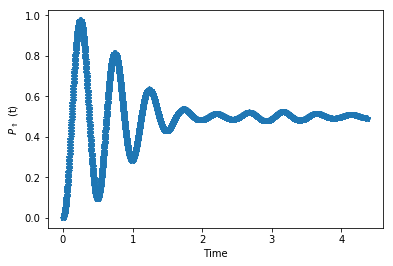

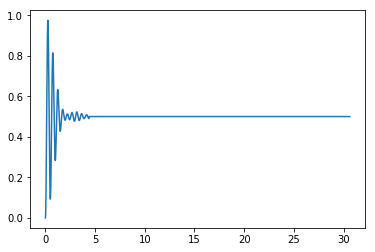

In [235]:
### Connect as in introduction


omegaP = 2 * 2*np.pi
sig_Rabi = 0.1*omegaP

gamma_SX = 0; gamma_PX = 0; gamma_SP = 0; gamma_PS = 0; 
psi0 = basis(3,1)  # initial state
dP = 0 #detuning

T= 1/800  # time
N= 500*7  # points in time domain

tlist = linspace(0, N*T, N)  # from 0 to N*T, with N points in total                  
Nruns = 500 # Number of runs... or independent atoms


time, exp0, exp1, exp2, exp3, exp4, exp5, omegaP_list = la3level_RWA_RabiFluctuations(tlist,psi0,omegaP,dP,gamma_SX,gamma_PX,gamma_SP,gamma_PS,sig_Rabi,Nruns)


### Plots of osc
ylabel(r'$P_{ \Uparrow}$ (t)')
xlabel('Time')
plot(time,exp1,'-*')


###################
free = 7
addd = 6*N

figure(2)
yapp = np.concatenate((exp1, np.array(np.ones(addd)/2)))
tlistapp = np.concatenate((time, linspace(N*T, free*N*T, addd)))
plot(tlistapp,yapp)




4200
24500


(0, 0.5)

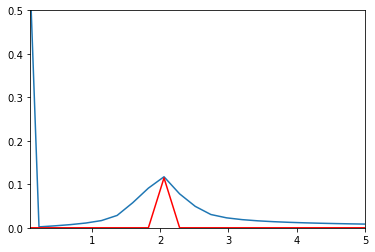

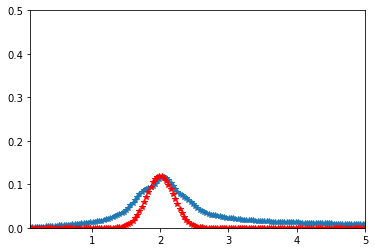

In [242]:

# Number of samplepoints
#N = 600
# sample spacing
#T = 1.0 / 800.0
#tlist x = np.linspace(0.0, N*T, N)
#exp1 y = np.sin(50.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(exp1)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

xff = np.linspace(0.0, 1.0/(2.0*T), 1*N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plot(xff,0.53*exp(-((xff-2)**2/(2*(0.1*2/6)**2))),'r')
ax.set_xlim([0.1,5])
ax.set_ylim([0,0.5])



figure(4)

yff = scipy.fftpack.fft(yapp)
xff = np.linspace(0.0, 1.0/(2.0*T), free*N/2)

plot(xff, (2.0/N * np.abs(yff[:free*N//2]))**1,'*')
plot(xff,0.12*exp(-((xff-2)**2/(2*(0.1*2)**2))),'r*')
xlim([0.1,5])
ylim([0,0.5])





